<p align="center"><h1><font color = "blue"> Mini Pet-project #1 by Nikolay Luzhynski</font></h1></p>
<h2>Credit Scoring</h2>
</br>
<hr/>
<h4><b><i>Цель проекта:</i></b></h4> <i>Прогнозирование вероятности дефолта заемщика</i>
<h4><b><i>Входные данные:</i></b></h4> <i>Тренировочные данные были взяты из открытого соревнования на <a href = "https://www.kaggle.com/c/sf-dst-scoring" target="_blank">Kaggle</a></i>
    <h4><b><i>Используемые модели:</i></b></h4><i>LogisticRegression, LGBMClassifier, XGBClassifier, CatBoostClassifier</i>
<h4><b><i>Метрики качества модели:</i></b></h4><i>roc_auc_score, recall, precision, logloss</i>
<h4><b><i>Итоги:</i></b></h4>
<i>Были получены следующие результаты по каждой из метрик:</i>
<ul>
    <li><i><b>roc_auc_score</b> - 0.733621 при помощи CatBoostClassifier</i></li>
    <li><i><b>recall</b> - 0.663940 при помощи LogisticRegression</i></li>
    <li><i><b>precision</b> - 0.455128 при помощи XGBClassifier</i></li>
    <li><i><b>logloss</b> - 4.408611 при помощи XGBClassifier</i></li>
    </ul>
<b><i>В зависимости от целей предсказания необходимо выбирать соответствующую модель.</i></b>
<hr/>

<h2>Содержание</h2>

[1.Импорт библиотек и данных](#1_1)

[2.Предварительная обработка данных](#2_1)

[3.Предварительный анализ данных](#3)

[4.Подготовка к обучению/feature engineering](#4)

[5.Построение моделей](#5)

[6. Анализ важных компонент](#6)

[7. Построение моделей бустинга](#7)

[8. Построение нейросетей](#8)

<a id='1_1'><h2>1.1 Импорт библиотек</h2></a>


In [1]:
# базовые библиотеки
import pandas as pd
import numpy as np
import scipy.stats as scp

# библиотеки для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot
init_notebook_mode(connected=True)

%config InlineBackend.figure_format = 'svg' # графики в svg выглядят более четкими
from pylab import rcParams # увеличим дефолтный размер графиков
rcParams["figure.figsize"] = 8, 5

# библиотеки для построения моделей
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_recall_curve,\
classification_report,precision_score, f1_score, log_loss, roc_auc_score, auc, roc_curve, confusion_matrix

# уберем всплывающие ошибки
import warnings
warnings.filterwarnings('ignore')
# отметим random state для воспроизводимости результатов
RAND = 8

<a id='1_2'><h2>1.2 Импорт данных</h2></a>

In [2]:
path = "datasets/" # искомая папка с датасетами
train_df = pd.read_csv(path + 'train.csv', index_col = 'client_id')

In [3]:
print(f'Размер тренировочной выборки:{train_df.shape}')

Размер тренировочной выборки:(73799, 18)


In [4]:
train_df.head()

,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
client_id,,,,,,,,,,,,,,,,,,
25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


<a id='2_1'><h2>2. Обработка данных</h2></a>

In [5]:
train_df.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73799 entries, 25905 to 15796
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   app_date          73799 non-null  object 
 1   education         73492 non-null  object 
 2   sex               73799 non-null  object 
 3   age               73799 non-null  int64  
 4   car               73799 non-null  object 
 5   car_type          73799 non-null  object 
 6   decline_app_cnt   73799 non-null  int64  
 7   good_work         73799 non-null  int64  
 8   score_bki         73799 non-null  float64
 9   bki_request_cnt   73799 non-null  int64  
 10  region_rating     73799 non-null  int64  
 11  home_address      73799 non-null  int64  
 12  work_address      73799 non-null  int64  
 13  income            73799 non-null  int64  
 14  sna               73799 non-null  int64  
 15  first_time        73799 non-null  int64  
 16  foreign_passport  73799 non-null  ob

In [6]:
train_df.describe(include='int64')

,age,decline_app_cnt,good_work,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,default
count,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000,73799.000000
mean,39.280641,0.275749,0.164894,2.000339,56.725701,1.575509,2.496280,41099.775417,1.733330,2.765458,0.126994
std,11.520378,0.804272,0.371087,2.252073,13.055717,0.527631,0.689818,46166.322400,1.123622,1.009463,0.332968
min,21.000000,0.000000,0.000000,0.000000,20.000000,1.000000,1.000000,1000.000000,1.000000,1.000000,0.000000
25%,30.000000,0.000000,0.000000,0.000000,50.000000,1.000000,2.000000,20000.000000,1.000000,2.000000,0.000000
50%,37.000000,0.000000,0.000000,1.000000,50.000000,2.000000,3.000000,30000.000000,1.000000,3.000000,0.000000
75%,48.000000,0.000000,0.000000,3.000000,60.000000,2.000000,3.000000,48000.000000,2.000000,4.000000,0.000000
max,72.000000,33.000000,1.000000,53.000000,80.000000,3.000000,3.000000,1000000.000000,4.000000,4.000000,1.000000


In [7]:
print(f'Признаки по каждому клиенту')
list(train_df.columns)

Признаки по каждому клиенту


['app_date',
 'education',
 'sex',
 'age',
 'car',
 'car_type',
 'decline_app_cnt',
 'good_work',
 'score_bki',
 'bki_request_cnt',
 'region_rating',
 'home_address',
 'work_address',
 'income',
 'sna',
 'first_time',
 'foreign_passport',
 'default']

<head><strong>Описания полей</strong></head>
<ul>
    <li><b>client_id</b> - идентификатор клиента</li>
    <li><b>education</b> - уровень образования</li>
    <li><b>sex</b> - пол заемщика</li>
    <li><b>age</b> - возраст заемщика</li>
    <li><b>car</b> - флаг наличия автомобиля</li>
    <li><b>car_type</b> - флаг автомобиля иномарки</li>
    <li><b>decline_app_cnt</b> - количество отказанных прошлых заявок</li>
    <li><b>good_work</b> - флаг наличия “хорошей” работы</li>
    <li><b>bki_request_cnt</b> - количество запросов в БКИ</li>
    <li><b>home_address</b> - категоризатор домашнего адреса</li>
    <li><b>work_address</b> - категоризатор рабочего адреса</li>
    <li><b>income</b> - доход заемщика</li>
    <li><b>foreign_passport</b> - наличие загранпаспорта</li>
    <li><b>sna</b> - связь заемщика с клиентами банка</li>
    <li><b>first_time</b> - давность наличия информации о заемщике</li>
    <li><b>score_bki</b> - скоринговый балл по данным из БКИ</li>
    <li><b>region_rating</b> - рейтинг региона</li>
    <li><b>app_date</b> - дата подачи заявки</li>
    <li><b>default</b> - флаг дефолта по кредиту</li>
</ul>

<h3>Проверим каждую переменную на пропуски</h3>

In [8]:
for i in train_df.columns:
    print(f'{i} - Количество пропусков {train_df[i].isnull().sum()}')

app_date - Количество пропусков 0
education - Количество пропусков 307
sex - Количество пропусков 0
age - Количество пропусков 0
car - Количество пропусков 0
car_type - Количество пропусков 0
decline_app_cnt - Количество пропусков 0
good_work - Количество пропусков 0
score_bki - Количество пропусков 0
bki_request_cnt - Количество пропусков 0
region_rating - Количество пропусков 0
home_address - Количество пропусков 0
work_address - Количество пропусков 0
income - Количество пропусков 0
sna - Количество пропусков 0
first_time - Количество пропусков 0
foreign_passport - Количество пропусков 0
default - Количество пропусков 0


<h4>Мы видим, что доля пропусков небольшая, поэтому посмотрим распределение пееременной Education и заполним пропуски модой</h4>

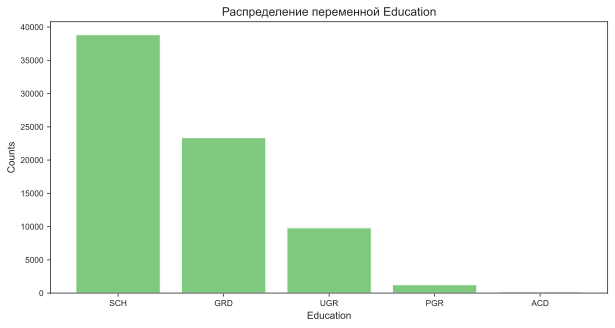

In [9]:
sns.set_palette('Accent')
sns.set_style('ticks')
fig, ax = plt.subplots()
ax.bar(height=train_df['education'].value_counts(),
        x = train_df['education'].dropna().unique()
        )
ax.set_xlabel('Education')
ax.set_ylabel('Counts')
ax.tick_params(labelsize = 'small')
ax.set_title('Распределение переменной Education')
fig.set_size_inches(10, 5)

In [10]:
print('Распределение переменной Education в процентном соотношении')
round(train_df['education'].value_counts(normalize = True)*100,2)

Распределение переменной Education в процентном соотношении


SCH    52.88
GRD    31.79
UGR    13.36
PGR     1.71
ACD     0.26
Name: education, dtype: float64

In [11]:
train_df['education'].fillna(train_df['education'].mode()[0], inplace=True) # заполняем пропуски модой

In [12]:
sum(train_df.isnull().sum())

0

<h3>Приведем формат даты к pd.datetime</h3>

In [13]:
train_df['app_date'] = train_df['app_date'].apply(lambda x : pd.to_datetime(x))

In [14]:
train_df['app_date'].head()

client_id
25905    2014-02-01
63161    2014-03-12
25887    2014-02-01
16222    2014-01-23
101655   2014-04-18
Name: app_date, dtype: datetime64[ns]

<h3>Разобьем переменные на категории</h3>

In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73799 entries, 25905 to 15796
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   app_date          73799 non-null  datetime64[ns]
 1   education         73799 non-null  object        
 2   sex               73799 non-null  object        
 3   age               73799 non-null  int64         
 4   car               73799 non-null  object        
 5   car_type          73799 non-null  object        
 6   decline_app_cnt   73799 non-null  int64         
 7   good_work         73799 non-null  int64         
 8   score_bki         73799 non-null  float64       
 9   bki_request_cnt   73799 non-null  int64         
 10  region_rating     73799 non-null  int64         
 11  home_address      73799 non-null  int64         
 12  work_address      73799 non-null  int64         
 13  income            73799 non-null  int64         
 14  sna               

In [16]:
time_cols = ['app_date'] # временной ряд (1)
bin_cols = ['sex','car','car_type', 
            'good_work', 'foreign_passport'] # бинарные переменные (default не включаем в список) (5+1 = 6)
cat_cols = ['education', 'region_rating', 'home_address', 
            'work_address', 'sna', 'first_time'] # категориальные переменные (6)
num_cols = ['age', 'decline_app_cnt', 'score_bki', 
            'bki_request_cnt', 'income'] # численные переменные (5)

In [17]:
train_df[cat_cols] = train_df[cat_cols].astype('object')

<h3>Посмотрим на уникальные значения по каждой категориальной переменной</h3>

In [18]:
for i in train_df[cat_cols]:
    print(i, train_df[i].unique())

education ['SCH' 'GRD' 'UGR' 'PGR' 'ACD']
region_rating [50 80 60 40 70 20 30]
home_address [1 2 3]
work_address [2 3 1]
sna [4 1 2 3]
first_time [1 4 3 2]


<a id='3'><h2>3. Предварительный анализ данных</h2></a>

<h3>3.1 Рассмотрим распределение целевой переменной и ее взаимосвязь с признаками</h3>

In [19]:
round(train_df['default'].value_counts(normalize=True),2)

0    0.87
1    0.13
Name: default, dtype: float64

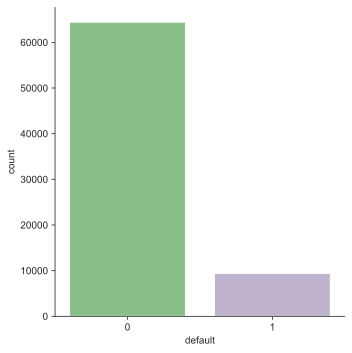

In [20]:
sns.catplot(kind = 'count', data = train_df, x = 'default');

<h4>Мы видим, что у нас дисбаланс классов, поэтому необходимо это учитывать при обучении модели</h4>

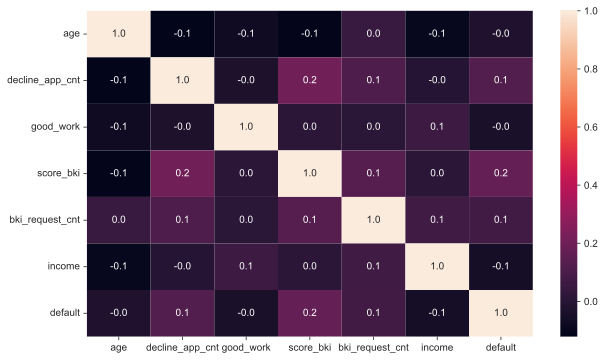

In [21]:
plt.figure(figsize=(10,6))
sns.heatmap(train_df.corr(method='spearman'), annot=True, fmt = ".1f");

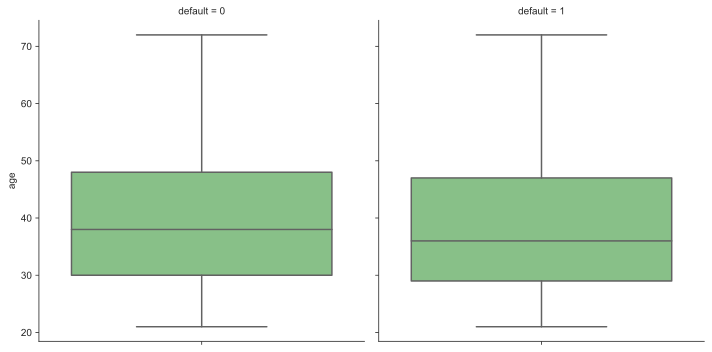

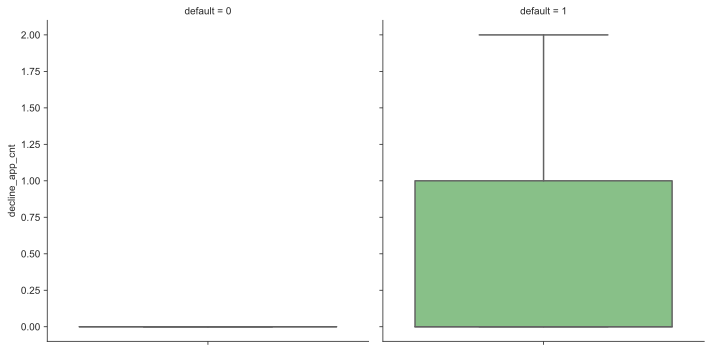

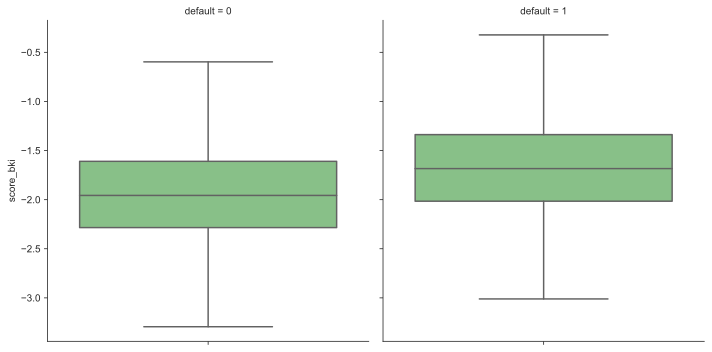

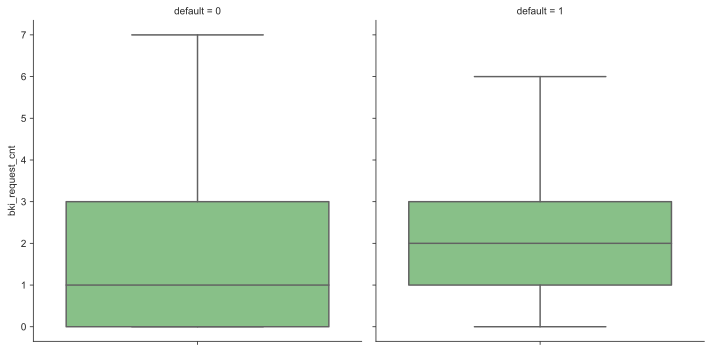

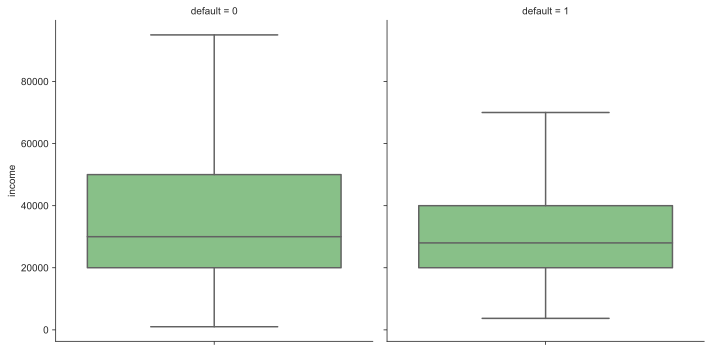

In [22]:
for i in train_df[num_cols]:
    sns.catplot(kind = 'box', data = train_df, y = i, col = 'default', sym ='')

<h4>Вывод: существенной взаимосвязи количественных переменных с целевой переменной не обнаружено</h4>

<h2>3.2 Сформулируем гипотезы и попробуем более подробно изучить данные</h2>

<h4>Гипотезы:</h4>
<ul>
    <li>Возраст "хороших" заемщиков больше, по сравнению с "плохими" заемциками (распределение возраста в зависимости от флага дефолта смещено в большую сторону при default = 0)</li>
    <li> Уровень образования зависит от возраста, что влияет и на возврат кредита, также люди с высшим образованием чаще является "хорошими" заемщиками</li>
    <li>При good_work увеличивается риск невозврата кредита</li>
    <li>Доход "хороших" заемщиков выше, чем "плохих"</li>
    <li>score_bki напрямую взаимосвязан с default, чем он меньше, тем выше вероятность клиента выплатить кредит банку</li>
    <li>Количество отклоненных заявок напрямую влияет на возврат кредита. Чем больше было отказанных заявок у клиента, тем более вероятно, что он окажется "плохим" заемщиком</li>
</ul>

<h2>Исследование переменной Age</h2>

<b>Гипотеза:</b> <font size=3 color = '#8A2BE2'>Возраст "хороших" заемщиков больше, по сравнению с "плохими" заемциками</font>

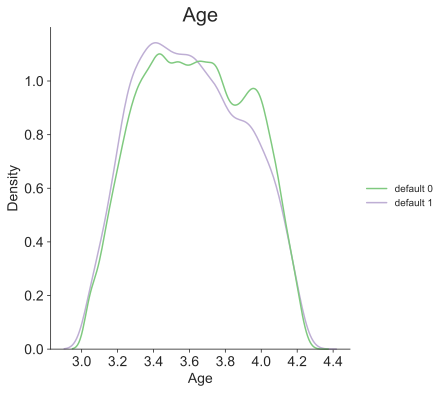

In [23]:
# посмотрим распределение в зависимости от флага по default, 
# поскольку распределение далеко от нормального - залогарифмируем данные
age_d0 = np.log(train_df[train_df.default == 0].age) 
age_d1 = np.log(train_df[train_df.default == 1].age)
sns.displot(
    {
        "default 0": age_d0,
        "default 1": age_d1
    },
    kind = 'kde',
    common_norm = False) # независимая нормализация каждого подмножества
plt.title('Age', fontsize = 20)
plt.xlabel('Age', fontsize = 14)
plt.ylabel('Density', fontsize = 14)

plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14);

<h4>Видим небольшое смещение вправо у тех клиентов, которые возвращают кредит. Рассмотрим в численном формате.</h4>

In [24]:
print(f'Значение медианы возраста для "хороших" клиентов: {train_df[train_df.default == 0].age.median()}')
print(f'Значение медианы возраста для "плохих" клиентов: {train_df[train_df.default == 1].age.median()}')

Значение медианы возраста для "хороших" клиентов: 38.0
Значение медианы возраста для "плохих" клиентов: 36.0


In [25]:
print(f'Значение среднего возраста для "хороших" клиентов: {round(train_df[train_df.default == 0].age.mean(),2)}')
print(f'Значение среднего возраста для "плохих" клиентов: {round(train_df[train_df.default == 1].age.mean(),2)}')

Значение среднего возраста для "хороших" клиентов: 39.39
Значение среднего возраста для "плохих" клиентов: 38.53


In [26]:
print(f'Значение моды возраста для "хороших" клиентов: {train_df[train_df.default == 0].age.mode()[0]}')
print(f'Значение моды возраста для "плохих" клиентов: {train_df[train_df.default == 1].age.mode()[0]}')

Значение моды возраста для "хороших" клиентов: 31
Значение моды возраста для "плохих" клиентов: 26


<b>Вывод:</b> <font size = 3 color = 'LimeGreen'>Гипотеза о возрасте подтвердилась - у нас есть основания полагать, что возраст влияет на возврат кредита </font>

<h2>Исследование переменной Education</h2>

<b>Гипотеза:</b> <font size=3 color = '#8A2BE2'>Уровень образования зависит от возраста, что влияет и на возврат кредита, также люди с высшим образованием чаще является "хорошими" заемщиками</font>

<h4>Примерная расшифровка признаков по переменной Education</h4>
<ul>
    <li>SCH - school education</li>
    <li>GRD - graduated</li>
    <li>UGR - Бакалавриат</li>
    <li>PGR - Аспирант</li>
    <li>ACD - Академик</li>
</ul>

In [27]:
round(train_df['education'].value_counts(normalize=True).mul(100),2) # процентное распределение

SCH    53.07
GRD    31.66
UGR    13.30
PGR     1.70
ACD     0.26
Name: education, dtype: float64

<h4>Видим, что большинство клиентов имеют лишь школьное образование (класс SCH), а меньше всего - Академиков (класс ACD).</h4>
<h4>Рассмотрим, изменяется ли распределение для "хороших" и "плохих" клиентов</h4>

In [28]:
round(train_df.groupby('default')['education'].apply(lambda x: x.value_counts(normalize = True)).mul(100),2)

default     
0        SCH    51.66
         GRD    33.00
         UGR    13.23
         PGR     1.83
         ACD     0.29
1        SCH    62.81
         GRD    22.46
         UGR    13.78
         PGR     0.86
         ACD     0.09
Name: education, dtype: float64

<h4>Посмотрим barplot</h4>

In [29]:
df_education_perc = train_df.groupby('default')['education']\
    .value_counts(normalize = True).rename('percentage').mul(100).reset_index()
trace0 = go.Bar(x=df_education_perc[df_education_perc['default'] == 0]['education'], 
                y=df_education_perc[df_education_perc['default'] == 0]['percentage'], 
                name="Not default")

trace1 = go.Bar(x=df_education_perc[df_education_perc['default'] == 1]['education'], 
                y=df_education_perc[df_education_perc['default'] == 1]['percentage'], 
                name="Default")

data = [trace0, trace1]
layout = {"title": "Age-Education"}

fig = go.Figure(data=data, layout=layout)

iplot(fig, show_link=False)

Уже можно заметить, распределение клиентов по виду их образования может стать хорошим признаком для модели, "плохих" клиентов c SCH уже более 62% от всех клиентов ("плохих" - 52%). Также можем видеть, что клиенты с образованием GRD, PGR, ACD лучше остальных "возвращают" кредиты

<h4>Посмотрим на график распределения и boxplot возраста клиентов в зависимости от их типа образования</h4>

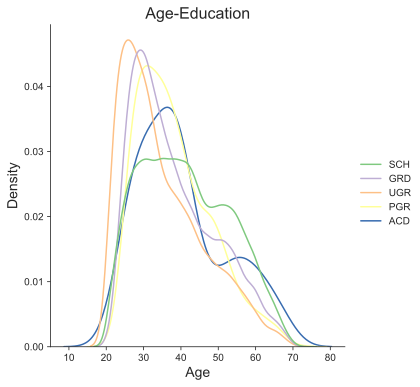

In [30]:
sns.displot({
    'SCH': train_df[train_df['education'] == 'SCH']['age'],
    'GRD': train_df[train_df['education'] == 'GRD']['age'],
    'UGR': train_df[train_df['education'] == 'UGR']['age'],
    'PGR': train_df[train_df['education'] == 'PGR']['age'],
    'ACD': train_df[train_df['education'] == 'ACD']['age'],
}, kind = 'kde',common_norm = False)
plt.title('Age-Education', fontsize = 16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Density', fontsize=14);

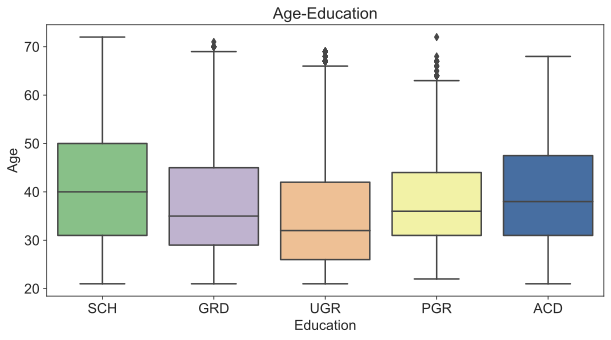

In [31]:
plt.figure(figsize=(10,5))

sns.boxplot(data = train_df, x = 'education', y = 'age')

plt.title('Age-Education', fontsize = 16)
plt.xlabel('Education', fontsize = 14)
plt.ylabel('Age', fontsize = 14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

In [32]:
round(train_df.groupby(['education', 'default'])['age'].mean(),1)

education  default
ACD        0          40.3
           1          37.0
GRD        0          38.1
           1          37.6
PGR        0          38.2
           1          39.3
SCH        0          41.4
           1          39.7
UGR        0          34.9
           1          34.7
Name: age, dtype: float64

In [33]:
round(train_df.groupby('education')['age'].mean(),2).sort_values(ascending = False)

education
SCH    41.15
ACD    40.15
PGR    38.25
GRD    38.05
UGR    34.86
Name: age, dtype: float64

<h4>Видим, что самыми молодыми является клиенты с UGR, что может и являться для нас признаком при определении "плохих" клиентов.</h4>
<h4>Посмотрим еще графики в зависимости от возврата/не возврата кредита</h4>

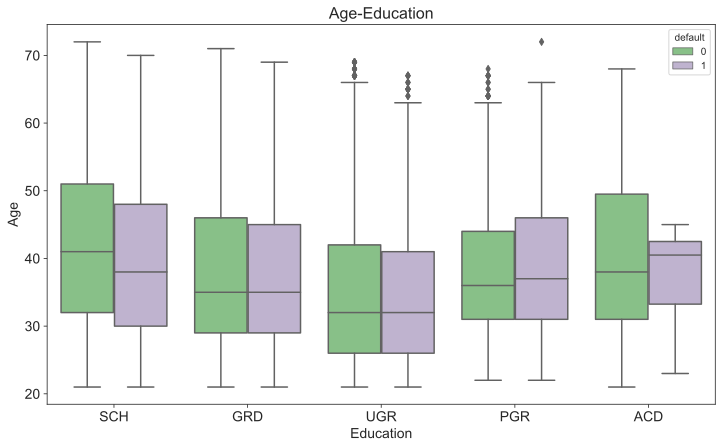

In [34]:
plt.figure(figsize=(12,7))

sns.boxplot(data = train_df, x = 'education', y = 'age', hue = 'default')

plt.title('Age-Education', fontsize = 16)
plt.xlabel('Education', fontsize = 14)
plt.ylabel('Age', fontsize = 14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

Интересно, что если мы берем уровень образования ACD и PGR, то у "плохих" клиентов средний возраст кажется выше, чем у "хороших". Однако мы видим, что разброс значений высокий и у тех, и у тех. Возможно, если мы возьмем какой-то промежуток, например с 30 до 50 лет, данный показатель не будет сильно влиять на полную выплату кредита.

<b>Вывод:</b> <font size = 3 color = 'LimeGreen'>Гипотеза об связи образования с возвратом кредита частично подтвердилась  - люди с более хорошим образованием чаще возвращают кредиты</font>

<h2> Исследование переменной Income</h2>

<b>Гипотеза:</b> <font size=3 color = '#8A2BE2'>Доход "хороших" заемщиков выше, чем "плохих"</font>

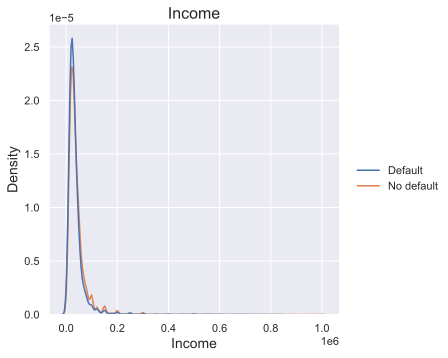

In [35]:
sns.set()
sns.displot({
    'Default': train_df[train_df['default'] == 1]['income'],
    'No default': train_df[train_df['default'] == 0]['income']
}, kind = 'kde',common_norm = False)
plt.title('Income', fontsize = 16)
plt.xlabel('Income', fontsize=14)
plt.ylabel('Density', fontsize=14);

<h4>Распределение у признака не нормальное, поэтому попробуем логарифмировать признак.</h4>

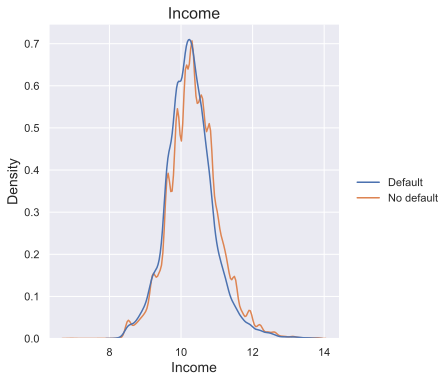

In [36]:
sns.displot({
    'Default': np.log(train_df[train_df['default'] == 1]['income']),
    'No default': np.log(train_df[train_df['default'] == 0]['income'])
}, kind = 'kde',common_norm = False)
plt.title('Income', fontsize = 16)
plt.xlabel('Income', fontsize=14)
plt.ylabel('Density', fontsize=14);

<h4>Видим, что на по графику сложно что-либо понять, поэтому взглянем на численные значения.</h4>

In [37]:
round(train_df['income'].describe(),0)

count      73799.0
mean       41100.0
std        46166.0
min         1000.0
25%        20000.0
50%        30000.0
75%        48000.0
max      1000000.0
Name: income, dtype: float64

In [38]:
train_df.groupby('default')['income'].agg(['mean', 'median','std', 'max', 'min'])

,mean,median,std,max,min
default,,,,,
0,41799.713288,30000.0,46951.903104,1000000,1000
1,36288.113316,28000.0,40026.389614,830000,3700


<h4>Проверим гипотезу о взаимосвязи дохода клиента с его возвратом кредита. Для этого добавим критерий: доход выше средного/ниже среднего.</h4>

In [39]:
df_income = train_df[['income','default']]

In [40]:
df_income['flag_income'] = df_income['income'].apply(lambda x: x > train_df['income'].mean())
df_income['flag_income'] = df_income['flag_income'].map({False:'below',True:'above'})

In [41]:
df = pd.crosstab(df_income['default'], df_income['flag_income'])
df

flag_income,above,below
default,,
0,19734,44693
1,2129,7243


In [42]:
print(f'Доля клиентов с доходом выше среднего, которые вернули кредиты - ' ,
      round(df.loc[0,'above']/(df.loc[0,'below']+df.loc[0,'above'])*100,2), '%')
print(f'Доля клиентов с доходом выше среднего, которые не вернули кредиты - ' ,
      round(df.loc[1,'above']/(df.loc[1,'below']+df.loc[1,'above'])*100,2), '%')

Доля клиентов с доходом выше среднего, которые вернули кредиты -  30.63 %
Доля клиентов с доходом выше среднего, которые не вернули кредиты -  22.72 %


<b>Вывод:</b> <font size = 3 color = 'LimeGreen'> Мы можем утверждать, что клиенты, которые имеют доход выше среднего, более склоны к возврату кредита</font>

<a id='another_cell'></a>

<h2> Исследование переменной score_bki</h2>

<h4>Рассмотрим переменную score_bki - Скор балл по данным из бюро кредитных историй</h4>

<b>Гипотеза:</b> <font size=3 color = '#8A2BE2'>score_bki напрямую взаимосвязан с default, чем он меньше, тем выше вероятность клиента выплатить кредит банку</font>

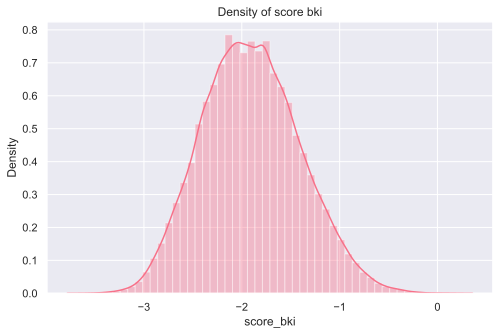

In [43]:
sns.set_palette('husl')
ax = sns.distplot(train_df['score_bki']) # рассмотрим распределение переменной score_bki
ax.set(title = 'Density of score bki');

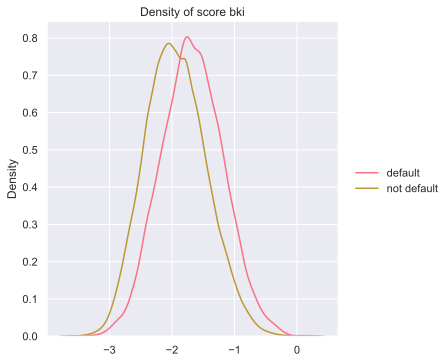

In [44]:
ax = sns.displot(
    {
        'default': train_df.query('default== 1')['score_bki'],
        'not default': train_df.query('default== 0')['score_bki']
    }, kind = 'kde', common_norm = False)
ax.set(title = 'Density of score bki');

In [45]:
train_df.groupby('default')['score_bki'].agg(('mean', 'median'))

,mean,median
default,,
0,-1.938048,-1.956982
1,-1.675637,-1.683857


<b>Вывод:</b> <font size = 3 color = 'LimeGreen'> Признак score_bki оказался значимым в определении "плохих" и "хороших" клиентов.</font>
<h4>Чем ниже значение score_bki -  тем выше вероятность выплаты кредита</h4>

<h2> Исследование переменной decline_app_cnt</h2>

<b>Гипотеза:</b> <font size=3 color = '#8A2BE2'>Количество отклоненных заявок напрямую влияет на возврат кредита. Чем больше было отказанных заявок у клиента, тем более вероятно, что он окажется "плохим" заемщиком</font>

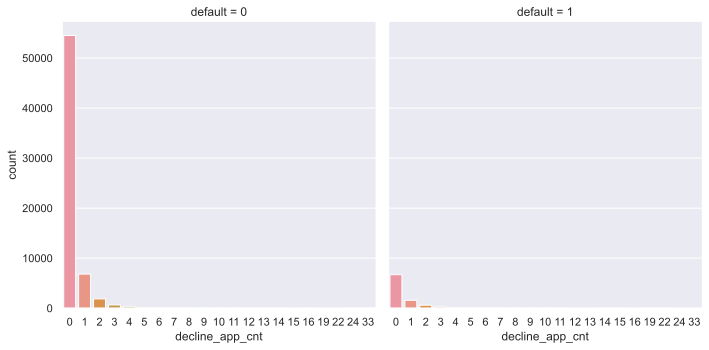

In [46]:
sns.catplot(data = train_df, kind = 'count', x = 'decline_app_cnt', col = 'default');

In [47]:
cross_df = pd.crosstab(columns = train_df['default'], index = train_df['decline_app_cnt'])
for i in cross_df:
    cross_df[i] = cross_df[i].apply(lambda x: round(x/cross_df[i].sum()*100,4))
cross_df

default,0,1
decline_app_cnt,,
0,84.6058,71.5429
1,10.5856,16.8267
2,2.8979,6.4127
3,1.0182,2.6355
4,0.4563,1.2804
5,0.1894,0.4588
6,0.1226,0.3628
7,0.0528,0.1494
8,0.0140,0.1067


<h4>Видим, что большинство клиентов были одобрены без отклонения заявок, поэтому добавим метку - Были ли отклоненные заявки у клиента</h4>

In [48]:
train_df['decline_app'] = train_df['decline_app_cnt'].apply(lambda x: 1 if x>0 else 0)

In [49]:
cross_df = pd.crosstab(columns = train_df['default'], index = train_df['decline_app'])
for i in cross_df:
    cross_df[i] = cross_df[i].apply(lambda x: round(x/cross_df[i].sum()*100,4))
cross_df

default,0,1
decline_app,,
0,84.6058,71.5429
1,15.3942,28.4571


<b>Вывод:</b> <font size = 3 color = 'LimeGreen'> Признак decline_app оказался значимым в определении "плохих" и "хороших" клиентов.</font>
<h4>Для клиентов с отклоненными заявками вероятность невозврата кредита больше, чем для клиентов без них</h4>

<a id='4'><h2>4. Feature Engineering</h2></a>

<h3>1. Рассмотрим количественные переменные</h3>

In [50]:
num_cols

['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']

In [51]:
numeric_features = train_df[num_cols]
numeric_features = numeric_features.stack().reset_index().rename(columns = {'level_1':'features', 0:'Values'})

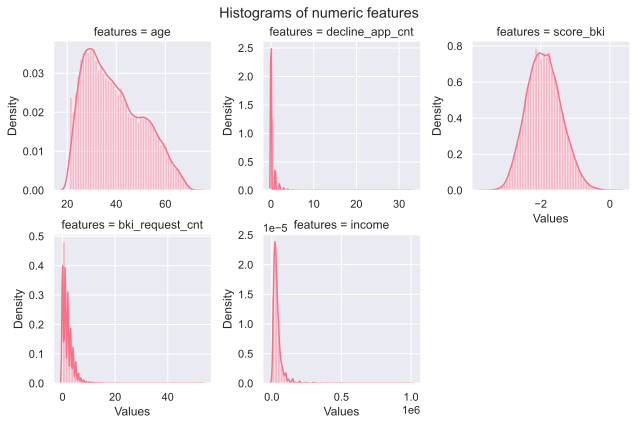

In [52]:
g = sns.FacetGrid(numeric_features,col = 'features', col_wrap = 3, sharex=False, sharey=False)
g = g.map(sns.distplot, 'Values')

plt.subplots_adjust(top=0.9)
plt.suptitle('Histograms of numeric features');

Видим, что показатели age, decline_app_cnt, bki_request_cnt и income имеют не номральное распределение. Попробуем их прологарифмировать

In [53]:
for i in ['age', 'decline_app_cnt', 'bki_request_cnt','income']:
    train_df[i] = np.log(train_df[i]+1)

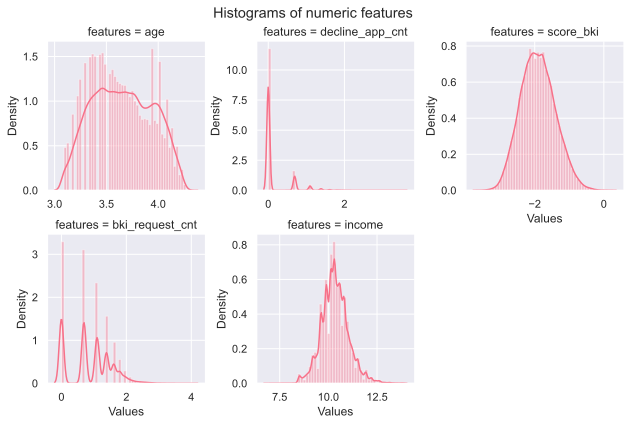

In [54]:
numeric_features = train_df[num_cols]
numeric_features = numeric_features.stack().reset_index().rename(columns = {'level_1':'features', 0:'Values'})

g = sns.FacetGrid(numeric_features,col = 'features', col_wrap = 3, sharex=False, sharey=False)
g = g.map(sns.distplot, 'Values')

plt.subplots_adjust(top=0.9)
plt.suptitle('Histograms of numeric features');


<h4>Распределение стало получше, однако обратим внимание на переменную decline_app_cnt. Возможно ее лучше убрать и оставить метку decline_app - были ли у клиента отклоненные заявки.</h4>

<h3>Добавим новые признаки</h3>

In [55]:
# новый признак - месяц
train_df['month'] = train_df['app_date'].dt.month.astype('int64')
# новый признак - день недели
train_df['day'] = train_df['app_date'].dt.weekday.astype('int64')
# удаляем исходный формат даты
train_df.drop('app_date', axis = 1, inplace =True)

In [56]:
# средний доход с учетом рейтинга региона
mean_inc_reg = train_df.groupby('region_rating')['income'].median().to_dict()
mean_inc_reg

{20: 10.043292972227004,
 30: 9.975584260236154,
 40: 10.12667110305036,
 50: 10.12667110305036,
 60: 10.308985993422082,
 70: 10.645448706505872,
 80: 10.757924157061597}

In [57]:
# добавим новый признак - средний доход с учетом рейтинга региона
train_df['mean_inc_reg'] = train_df['region_rating'].map(mean_inc_reg)

In [58]:
train_df.head()

,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,...,work_address,income,sna,first_time,foreign_passport,default,decline_app,month,day,mean_inc_reg
client_id,,,,,,,,,,,,,,,,,,,,,
25905,SCH,M,4.143135,Y,Y,0.000000,0,-2.008753,0.693147,50,...,2,9.798183,4,1,N,0,0,2,5,10.126671
63161,SCH,F,4.094345,N,N,0.000000,0,-1.532276,1.386294,50,...,3,9.852247,4,1,N,0,0,3,2,10.126671
25887,SCH,M,3.258097,Y,N,1.098612,0,-1.408142,0.693147,80,...,2,10.308986,1,4,Y,0,1,2,5,10.757924
16222,SCH,F,3.988984,N,N,0.000000,0,-2.057471,1.098612,50,...,3,9.210440,1,3,N,0,0,1,3,10.126671
101655,GRD,M,3.891820,N,N,0.000000,1,-1.244723,0.693147,60,...,3,10.308986,1,4,Y,0,0,4,4,10.308986


In [59]:
set(train_df.columns) - set(cat_cols) - set(num_cols) - set(bin_cols)

{'day', 'decline_app', 'default', 'mean_inc_reg', 'month'}

<a id='5'><h2>5. Построение моделей</a></h2>

<h2>Подготовим данные для обучения модели</h2>

In [60]:
cat_cols

['education',
 'region_rating',
 'home_address',
 'work_address',
 'sna',
 'first_time']

In [61]:
df_label = pd.get_dummies(train_df, columns = cat_cols, drop_first=True)

In [62]:
df_label.head()

,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,income,foreign_passport,...,home_address_2,home_address_3,work_address_2,work_address_3,sna_2,sna_3,sna_4,first_time_2,first_time_3,first_time_4
client_id,,,,,,,,,,,,,,,,,,,,,
25905,M,4.143135,Y,Y,0.000000,0,-2.008753,0.693147,9.798183,N,...,0,0,1,0,0,0,1,0,0,0
63161,F,4.094345,N,N,0.000000,0,-1.532276,1.386294,9.852247,N,...,1,0,0,1,0,0,1,0,0,0
25887,M,3.258097,Y,N,1.098612,0,-1.408142,0.693147,10.308986,Y,...,0,0,1,0,0,0,0,0,0,1
16222,F,3.988984,N,N,0.000000,0,-2.057471,1.098612,9.210440,N,...,1,0,0,1,0,0,0,0,1,0
101655,M,3.891820,N,N,0.000000,1,-1.244723,0.693147,10.308986,Y,...,1,0,0,1,0,0,0,0,0,1


In [63]:
# приведем бинарные признаки к 1/0
for i in train_df[bin_cols]:
    print(i, train_df[i].unique())

sex ['M' 'F']
car ['Y' 'N']
car_type ['Y' 'N']
good_work [0 1]
foreign_passport ['N' 'Y']


In [64]:
for i in ['car','car_type','foreign_passport']:
    df_label[i] = df_label[i].map({'Y':1, 'N':0})

In [65]:
df_label['sex_M'] = df_label['sex'].map({'M':1,'F':0})
df_label.drop('sex', axis = 1, inplace = True)

In [66]:
df_label[['month']] = df_label[['month']].astype('int64')
df_label[['day']] = df_label[['day']].astype('int64')

In [67]:
df_label.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73799 entries, 25905 to 15796
Data columns (total 35 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               73799 non-null  float64
 1   car               73799 non-null  int64  
 2   car_type          73799 non-null  int64  
 3   decline_app_cnt   73799 non-null  float64
 4   good_work         73799 non-null  int64  
 5   score_bki         73799 non-null  float64
 6   bki_request_cnt   73799 non-null  float64
 7   income            73799 non-null  float64
 8   foreign_passport  73799 non-null  int64  
 9   default           73799 non-null  int64  
 10  decline_app       73799 non-null  int64  
 11  month             73799 non-null  int64  
 12  day               73799 non-null  int64  
 13  mean_inc_reg      73799 non-null  float64
 14  education_GRD     73799 non-null  uint8  
 15  education_PGR     73799 non-null  uint8  
 16  education_SCH     73799 non-null  ui

In [68]:
# Разбиваем данные на тренировочные и тестовые данные, учитываем дисбаланс классов

X = df_label.drop('default', axis = 1)
y = df_label['default']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    stratify=y, 
                                                    shuffle=True, 
                                                    random_state=RAND)

In [69]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((51659, 34), (22140, 34), (51659,), (22140,))

In [70]:
y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)

(0    0.873013
 1    0.126987
 Name: default, dtype: float64,
 0    0.87299
 1    0.12701
 Name: default, dtype: float64)

<h2>Построение Baseline</h2>

<h4>Посколько нам необходимо предсказать вернет ли кредит клиент (1/0), то в качестве Baseline выберем логистическую регрессию. То есть попробуем предсказать вероятность возврата кредита. После чего посмотрим на roc auc</h4>

In [71]:
lr_base = LogisticRegression(class_weight='balanced')
lr_base.fit(X_train, y_train)

y_pred = lr_base.predict(X_test)
y_score = lr_base.predict_proba(X_test)[:,1]

<h4>Посмотрим на метрики</h4>

In [72]:
metrics = pd.DataFrame(
    index = ['roc-auc', 'recall','precision', 'f1','logloss'])
metrics['Baseline_LR'] = [roc_auc_score(y_test, y_score),
                          recall_score(y_test, y_pred),
                          precision_score(y_test, y_pred),
                          f1_score(y_test, y_pred),
                          log_loss(y_test, y_pred)]
metrics

,Baseline_LR
roc-auc,0.730206
recall,0.663940
precision,0.224130
f1,0.335128
logloss,11.556839


<h4>Построим ROC AUC</h4>

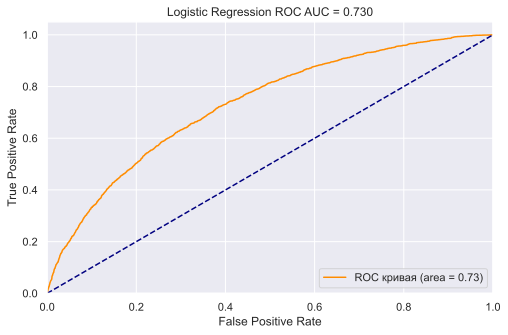

In [73]:
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.legend(loc="lower right")
plt.show()

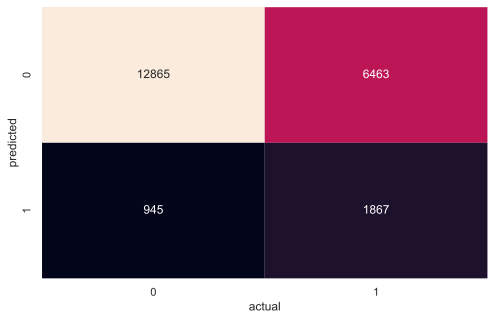

In [74]:
matrix = pd.crosstab(y_test, y_pred, rownames=['predicted'], colnames=['actual'])
sns.heatmap(matrix, annot = True, fmt='.5g', cbar=False);

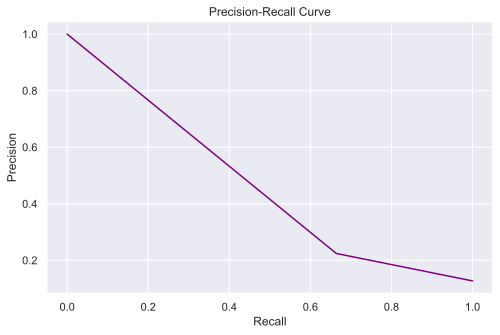

In [75]:
#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall');

<h2>Подбор параметров</h2>

In [76]:
parameters_grid = {
    'penalty' : ['l1','l2','elasticnet'],
    'C' : np.linspace(1,1000,5),
    'solver' : ['sag','saga','lbfgs'],
    'l1_ratio' : [0.25,0.5,0.75],
    'max_iter' : np.arange(100,500,100)
}
lr = LogisticRegression(class_weight='balanced')
cv = StratifiedKFold(n_splits=3, shuffle=True)
grid_cv = GridSearchCV(lr, parameters_grid, cv = cv, scoring='roc_auc', verbose = 2, n_jobs=-1)

In [77]:
%%time
#grid_cv.fit(X_train, y_train)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


In [78]:
#grid_cv.best_params_

In [79]:
best_params = {'C': 1.0,
 'l1_ratio': 0.25,
 'max_iter': 200,
 'penalty': 'l2',
 'solver': 'lbfgs'}

In [80]:
lr_grid = LogisticRegression(**best_params, class_weight='balanced')
lr_grid.fit(X_train, y_train)

y_pred_grid = lr_grid.predict(X_test)
y_score_grid = lr_grid.predict_proba(X_test)[:,1]

In [81]:
metrics['Grid_LR'] = [roc_auc_score(y_test, y_score_grid),
                          recall_score(y_test, y_pred_grid),
                          precision_score(y_test, y_pred_grid),
                          f1_score(y_test, y_pred_grid),
                          log_loss(y_test, y_pred_grid)]
metrics

,Baseline_LR,Grid_LR
roc-auc,0.730206,0.730473
recall,0.663940,0.662873
precision,0.224130,0.224119
f1,0.335128,0.334981
logloss,11.556839,11.545919


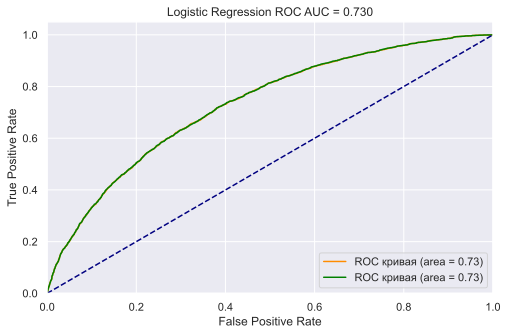

In [82]:
# рассчитываем roc-кривую
fpr_2, tpr_2, treshold_2 = roc_curve(y_test, y_score_grid)
roc_auc_2 = auc(fpr_2, tpr_2)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot(fpr_2, tpr_2, color='green',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc_2)
plt.legend(loc="lower right")
plt.show()

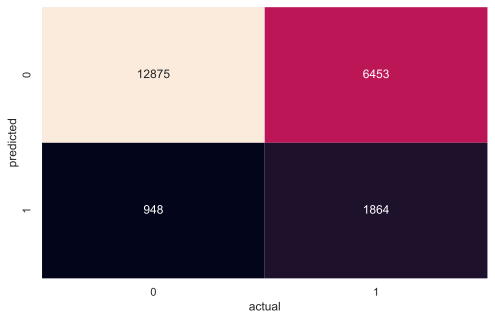

In [83]:
matrix = pd.crosstab(y_test, y_pred_grid, rownames=['predicted'], colnames=['actual'])
sns.heatmap(matrix, annot = True, fmt='.5g', cbar=False);

<h4>Видим, что подбор параметров сильно не помог

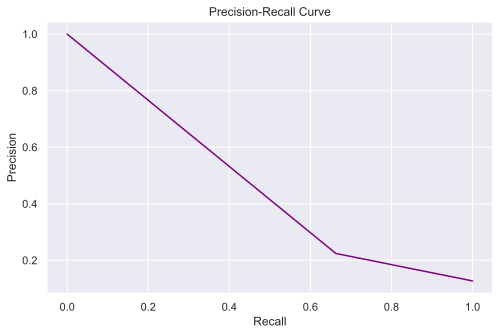

In [84]:
#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_grid)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall');

<a id='6'><h2>6. Анализ важных компонент</h2></a>

In [85]:
lr_grid.coef_

array([[-1.62143804e-01,  1.62723784e-02, -2.98359747e-01,
         2.68382074e-01, -2.24404312e-01,  9.86505767e-01,
         3.07289789e-01, -8.85566390e-03, -1.90610248e-01,
         1.54174441e-01, -1.07702745e-01, -1.70888657e-04,
         1.45833191e-01,  1.62093342e-01, -3.49419103e-02,
         6.14785031e-01,  4.66157726e-01,  5.10694841e-02,
        -1.30392974e-01, -4.01413821e-01, -5.58387590e-01,
        -1.09735441e+00, -1.36877752e+00,  5.54006274e-01,
         8.14366809e-03,  2.71084498e-01,  4.03516228e-01,
         2.95324915e-01,  1.94394513e-01,  4.73267059e-01,
         8.46181527e-02, -1.27706992e-01, -3.01266462e-01,
         2.74748079e-01]])

In [86]:
feature_imp = pd.DataFrame()
feature_imp['feature'] = X.columns
feature_imp['imp'] = lr_grid.coef_[0]
feature_imp = feature_imp.sort_values('imp', ascending = False)

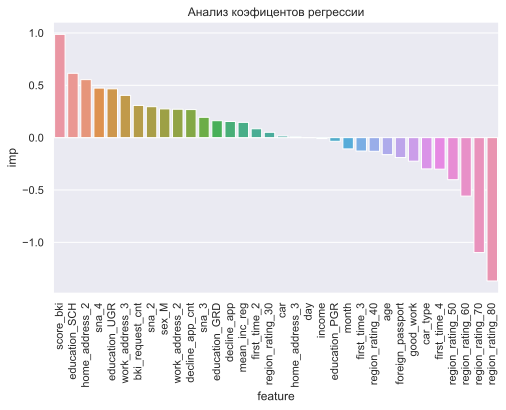

In [87]:
sns.barplot(data = feature_imp, x = 'feature', y = 'imp')
plt.title('Анализ коэфицентов регрессии')
plt.xticks(rotation=90);

<a id='7'><h2>7. Бустинг</h2></a>

## LGBMClassifier

In [88]:
import lightgbm as lgbm

In [89]:
clf_lgb = lgbm.LGBMClassifier(learning_rate = .1,
                              max_depth=4,
                              n_estimators=100,
                              objective='binary',
                              random_state=RAND)

In [90]:
clf_lgb.fit(X_train,y_train)
y_score = clf_lgb.predict_proba(X_test)[:,1]
y_pred = clf_lgb.predict(X_test)

In [91]:
metrics['LGBMClassifier'] = [roc_auc_score(y_test, y_score),
                          recall_score(y_test, y_pred),
                          precision_score(y_test, y_pred),
                          f1_score(y_test, y_pred),
                          log_loss(y_test, y_pred)]
metrics

,Baseline_LR,Grid_LR,LGBMClassifier
roc-auc,0.730206,0.730473,0.730729
recall,0.663940,0.662873,0.019203
precision,0.224130,0.224119,0.425197
f1,0.335128,0.334981,0.036747
logloss,11.556839,11.545919,4.416411


## XGBClassifier

In [92]:
import xgboost as xgb

In [93]:
clf_xgb = xgb.XGBClassifier(
    n_estimators = 200,
    learning_rate=0.1,
    max_depth=3,
    random_state=RAND)

In [94]:
clf_xgb.fit(X_train,y_train)

[20:50:52] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=8, num_parallel_tree=1, random_state=8,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [95]:
y_score = clf_xgb.predict_proba(X_test)[:,1]
y_pred = clf_xgb.predict(X_test)

In [96]:
metrics['XGBClassifier'] = [roc_auc_score(y_test, y_score),
                          recall_score(y_test, y_pred),
                          precision_score(y_test, y_pred),
                          f1_score(y_test, y_pred),
                          log_loss(y_test, y_pred)]
metrics

,Baseline_LR,Grid_LR,LGBMClassifier,XGBClassifier
roc-auc,0.730206,0.730473,0.730729,0.731508
recall,0.663940,0.662873,0.019203,0.025249
precision,0.224130,0.224119,0.425197,0.455128
f1,0.335128,0.334981,0.036747,0.047844
logloss,11.556839,11.545919,4.416411,4.408611


In [97]:
weigths = np.zeros(len(y_train))
weigths[y_train == 0] = 1
weigths[y_train == 1] = 2

In [98]:
d_train = xgb.DMatrix(data=X_train,label=y_train, weight=weigths)
d_test = xgb.DMatrix(data=X_test, label=y_test)

In [99]:
params = {'objective':'binary:logistic',"max_depth":3}

In [100]:
cv_results = xgb.cv(dtrain=d_train,
                    params=params,
                    nfold=4,
                    num_boost_round=50,
                    metrics='auc',
                    as_pandas=True
                    
)

Text(0, 0.5, 'auc')

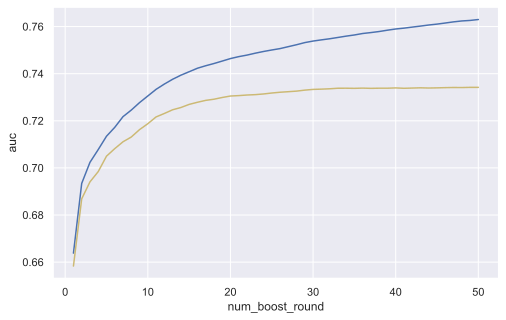

In [101]:
fig,ax = plt.subplots()
ax.plot(range(1,cv_results.shape[0]+1),cv_results['train-auc-mean'], color = 'b')
ax.plot(range(1,cv_results.shape[0]+1),cv_results['test-auc-mean'], color = 'y')

ax.set_xlabel("num_boost_round")
ax.set_ylabel("auc")

In [102]:
cv_results['test-auc-mean'].max()

0.73419925

In [103]:
params = {'objective':'binary:logistic',
          "max_depth":3, 
          "eval_metrics":'auc',
          "silent":1,"eta":1}
num_round=50
watch_list=[(d_train,'train'), (d_test,'test')]

In [104]:
xgb_model = xgb.train(params,d_train,num_round)

[20:50:59] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { eval_metrics, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:50:59] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


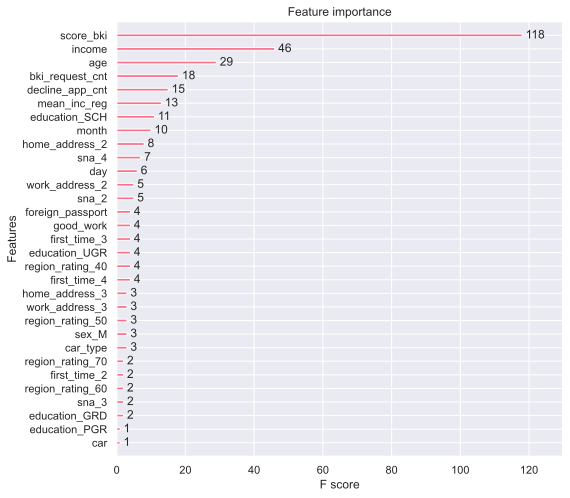

In [105]:
fig, ax = plt.subplots(figsize=(8,8))
xgb.plot_importance(xgb_model, ax=ax);

## Catboost

In [106]:
import catboost as cb

In [107]:
clf_cb = cb.CatBoostClassifier(n_estimators=2000,
                              learning_rate=.03,
                              max_depth=4,
                              random_state=RAND)

In [108]:
clf_cb.fit(X_train,y_train, verbose=False)

In [109]:
y_score = clf_cb.predict_proba(X_test)[:,1]
y_pred = clf_cb.predict(X_test)
metrics['CatBoostClassifier'] = [roc_auc_score(y_test, y_score),
                          recall_score(y_test, y_pred),
                          precision_score(y_test, y_pred),
                          f1_score(y_test, y_pred),
                          log_loss(y_test, y_pred)]
metrics

,Baseline_LR,Grid_LR,LGBMClassifier,XGBClassifier,CatBoostClassifier
roc-auc,0.730206,0.730473,0.730729,0.731508,0.733621
recall,0.663940,0.662873,0.019203,0.025249,0.028094
precision,0.224130,0.224119,0.425197,0.455128,0.431694
f1,0.335128,0.334981,0.036747,0.047844,0.052755
logloss,11.556839,11.545919,4.416411,4.408611,4.425772


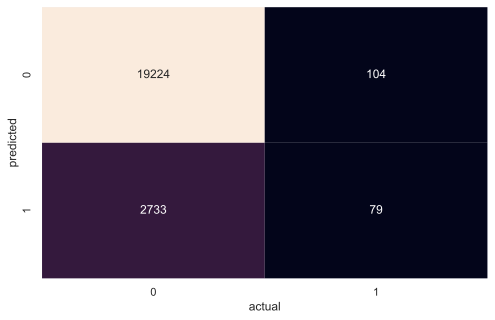

In [110]:
matrix = pd.crosstab(y_test, clf_cb.predict(X_test), rownames=['predicted'], colnames=['actual'])
sns.heatmap(matrix, annot = True, fmt='.5g', cbar=False);